In [94]:
%%writefile .gitignore 
.ipynb_checkpoints/
titanic.zip
submission.csv

Overwriting .gitignore


<h1> Titanic - Survival Rate Prediction </h1>

- Objective: Predict the survival rate of each passenger on the Titanic using the XGBoost model

- Steps to follow:
    1. Data Collection
    2. Exploratory Data Analysis
    3. Data Preprocessing 
    4. Feature Engineering
    5. Train test Split
    6. Model Selection
    7. Model Training and Evaluation
    8. Hyperparameter Tuning
    9. Model Validation 


<br>
<h3><b> 1. Data Collection </b></h3>

In [2185]:
import kaggle
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/Users/tungdinh/.kaggle"

!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [62]:
import zipfile

with zipfile.ZipFile('titanic.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [81]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print('GPU is available' if len(physical_devices) > 0 else 'Not available')

GPU is available


In [3]:
# Load the data
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

<br>
<h3><b> 2. Exploratory Data Analysis </b></h3>

In [4]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
test_data.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data.describe()
#test_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
print('TRAIN DATA:')
train_data.info()
print('\n####\n')
print('TEST DATA:')
test_data.info()

TRAIN DATA:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

####

TEST DATA:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non

- <b> Check for null values </b>

In [9]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [11]:
titanic_data = pd.concat([train_data, test_data])

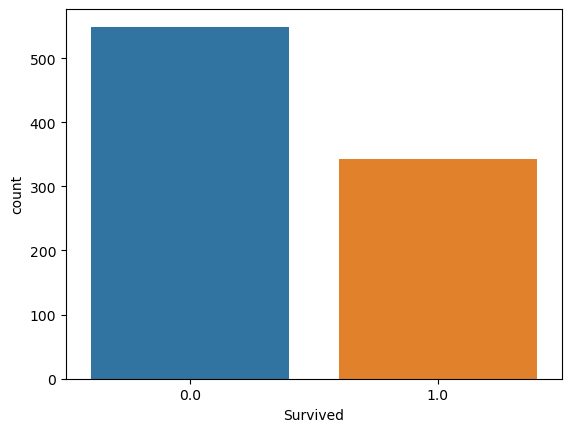

In [12]:
sns.countplot(x=titanic_data['Survived'])
plt.show()

#### <b> 2.1 Pclass (Ticket Class)  </b>

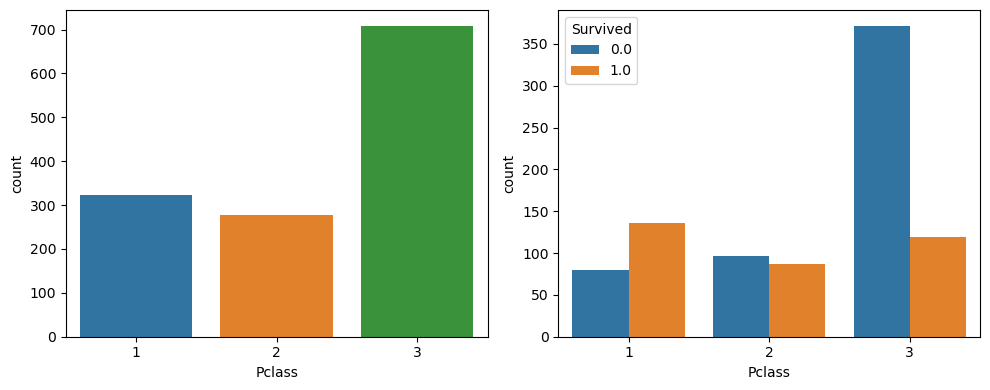

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=titanic_data['Pclass'], ax=axes[0])
sns.countplot(x=titanic_data['Pclass'], hue='Survived', data=titanic_data, ax=axes[1])

plt.tight_layout()
plt.show()

#### <b>2.2 Name</b>

In [14]:
# Look for duplicates:
duplicates = len(titanic_data) - len(pd.unique(titanic_data['Name']))
print(f'Number of duplicated names: {duplicates}')

Number of duplicated names: 2


In [15]:
titanic_data[titanic_data.duplicated('Name', keep=False)].sort_values('Name')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
289,290,1.0,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q
6,898,NaN,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
696,697,0.0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


We can safely assume that they are different people despite having the same names.

#### <b> 2.3 Sex/Gender </b>

In [16]:
titanic_data['Sex'].unique()

array(['male', 'female'], dtype=object)

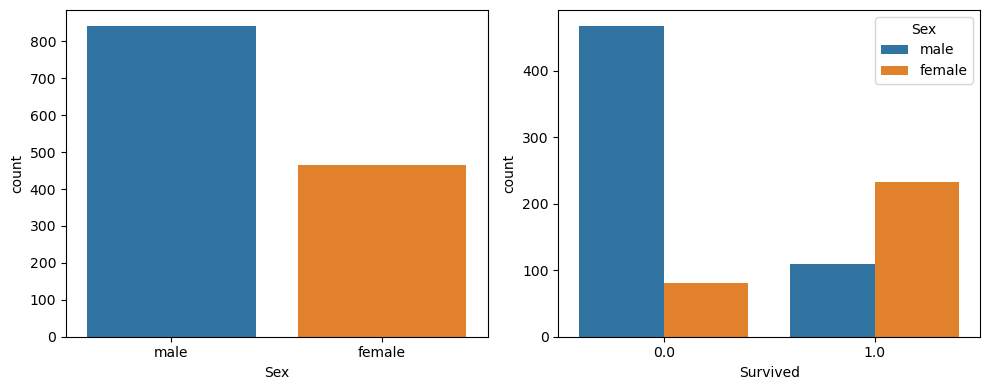

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=titanic_data['Sex'], ax=axes[0])
sns.countplot(x=titanic_data['Survived'], hue='Sex', data=titanic_data, ax=axes[1])

plt.tight_layout()
plt.show()

Interpretation: Despite the number of third class passengers is the highest, they are less likely to survive compared to the uppper classes. First class passengers are the most likely to survive. 

#### <b> 2.4 Age </b>

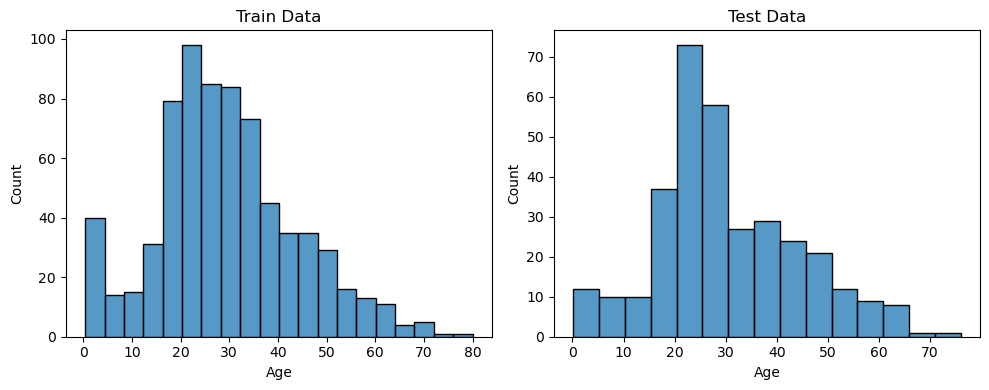

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(x=train_data['Age'].dropna(), ax=axes[0])
axes[0].set_title('Train Data')
sns.histplot(x=test_data['Age'].dropna(), ax=axes[1])
axes[1].set_title('Test Data')

plt.tight_layout()
plt.show()

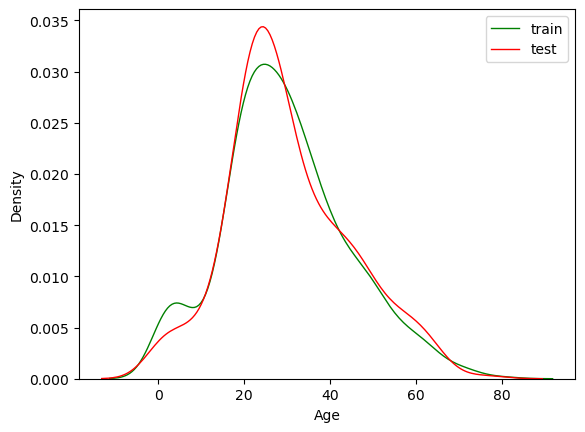

In [19]:
sns.kdeplot(data=train_data, x='Age', color='green', label='train', linewidth= 1)
sns.kdeplot(data=test_data, x='Age', color='red', label='test', linewidth= 1)
plt.legend()
plt.show()

The distribution of the 'Age' column is similar between the training and test data.

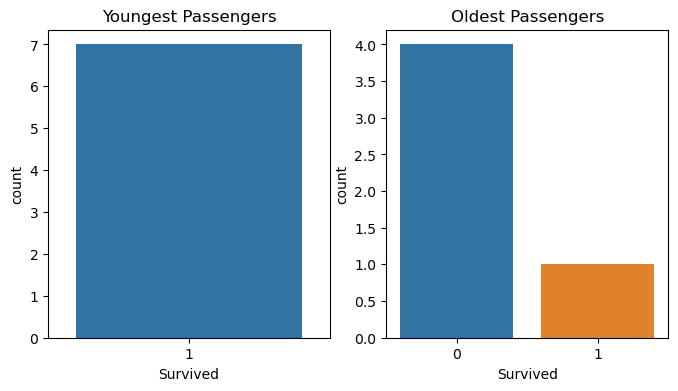

In [20]:
youngest_passengers = train_data[train_data['Age'] < 1]
oldest_passengers = train_data[train_data['Age'] > 70]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.countplot(x=youngest_passengers['Survived'], ax=axes[0])
axes[0].set_title('Youngest Passengers')
sns.countplot(x=oldest_passengers['Survived'], ax=axes[1])
axes[1].set_title('Oldest Passengers')

plt.show()

#### <b> 2.5 SibSp (Siblings/Spouse) </b>

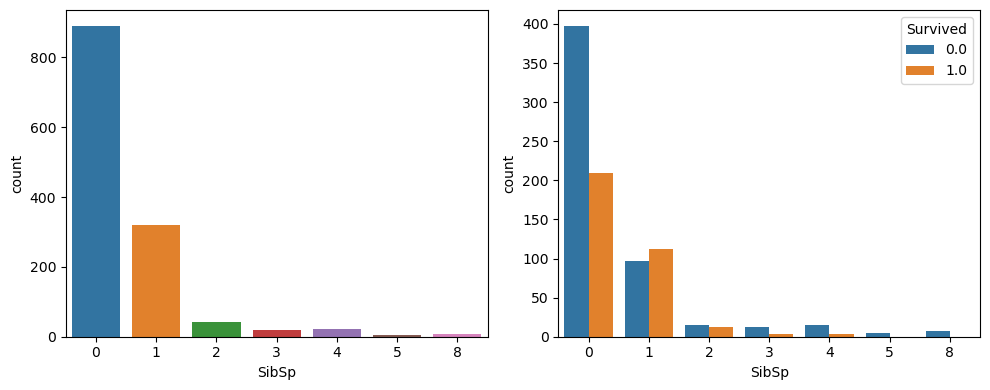

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=titanic_data['SibSp'], ax=axes[0])
sns.countplot(x=titanic_data['SibSp'], hue='Survived', data=titanic_data, ax=axes[1])

plt.tight_layout()
plt.show()                        

#### <b> 2.6 Parch (Parents/Children) </b>

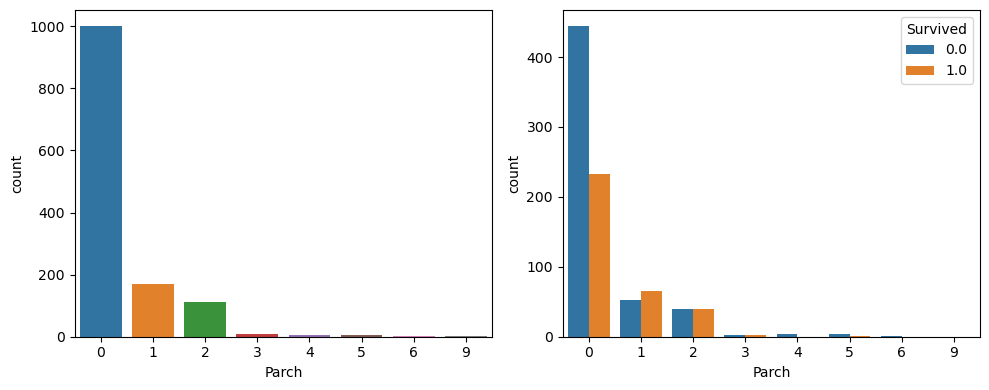

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=titanic_data['Parch'], ax=axes[0])

sns.countplot(x=titanic_data['Parch'], hue='Survived', data=titanic_data, ax=axes[1])

plt.tight_layout()
plt.show()

#### <b> 2.7 Fare </b>

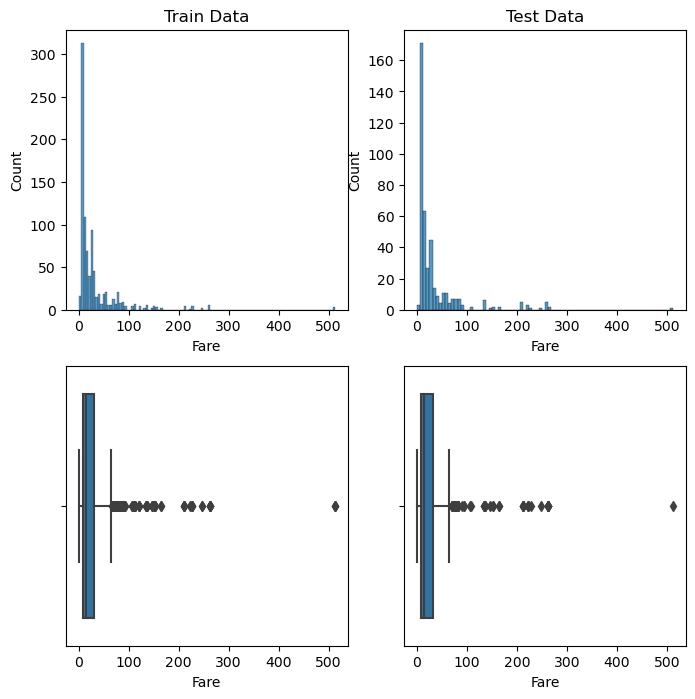

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

sns.histplot(train_data['Fare'], ax=axes[0][0])
axes[0][0].set_title('Train Data')
sns.histplot(test_data['Fare'], ax=axes[0][1])
axes[0][1].set_title('Test Data')

sns.boxplot(x=train_data['Fare'], ax=axes[1][0])
sns.boxplot(x=test_data['Fare'], ax=axes[1][1])


plt.show()


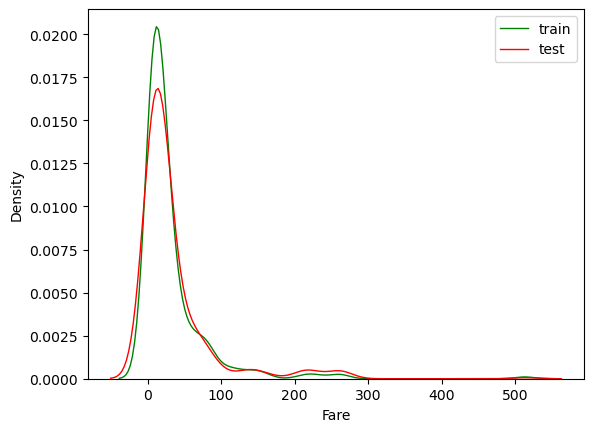

In [24]:
sns.kdeplot(data=train_data, x='Fare', color='green', label='train', linewidth= 1)
sns.kdeplot(data=test_data, x='Fare', color='red', label='test', linewidth= 1)
plt.legend()
plt.show()

Both train and test dataset have similar distribution of the 'Fare' values and displaying to be skewed left

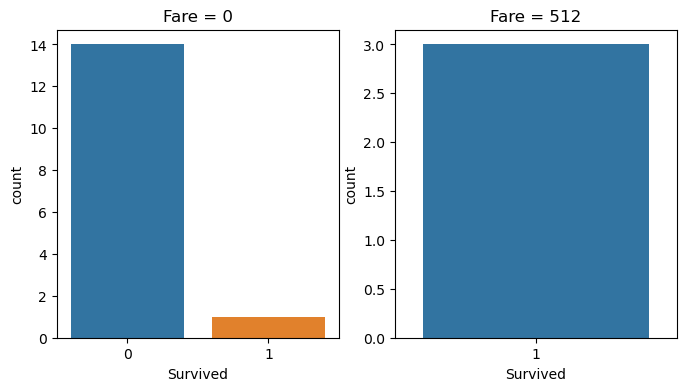

In [25]:
high_fare_passengers = train_data[train_data['Fare'] > int(max(train_data['Fare']))]
free_fare_passengers = train_data[train_data['Fare'] == int(min(train_data['Fare']))]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.countplot(x=free_fare_passengers['Survived'], ax=axes[0])
axes[0].set_title(f'Fare = {int(min(train_data["Fare"]))}')
sns.countplot(x=high_fare_passengers['Survived'], ax=axes[1])
axes[1].set_title(f'Fare = {int(max(train_data["Fare"]))}')

plt.show()

Only 1 passenger who did not pay survided (out of 14). In contrast, all the passengers who paid more than 500 survived. 

#### <b> 2.7 Cabin </b>

In [26]:
train_data['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [27]:
# check a random passenger who have more than 1 cabin number
train_data[train_data['Cabin'] == 'C22 C26']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S


This indicates that they're likely a family who travel together (have the same ticket number)

In [28]:
titanic_data['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

There are 8 unique cabin types if grouped by the leading letter. 

#### <b> 2.8 Embarked </b>

In [29]:
titanic_data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

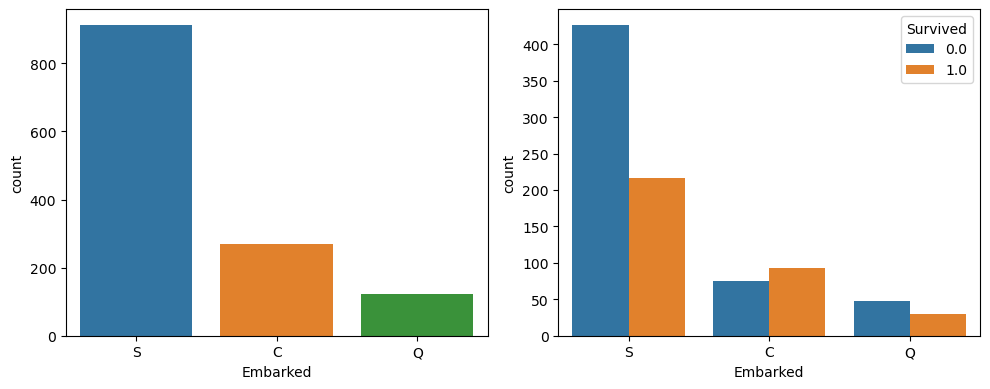

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=titanic_data['Embarked'], ax=axes[0])
sns.countplot(x=titanic_data['Embarked'], hue='Survived', data=titanic_data, ax=axes[1])

plt.tight_layout()
plt.show()

Passengers who are embarked from C are more likely to survive than the others. We're going to investgate how this feature influences the survival rate.

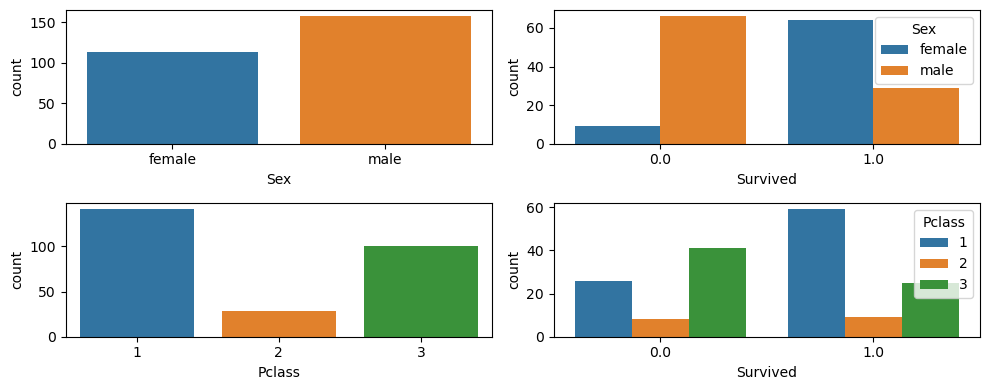

In [31]:
embarked_C = titanic_data[titanic_data['Embarked'] == 'C']

fig, axes = plt.subplots(2, 2, figsize=(10, 4))

sns.countplot(x=embarked_C['Sex'], ax=axes[0][0])
sns.countplot(x=embarked_C['Survived'], hue='Sex', data=embarked_C, ax=axes[0][1])

sns.countplot(x=embarked_C['Pclass'], ax=axes[1][0])
sns.countplot(x=embarked_C['Survived'], hue='Pclass', data=embarked_C, ax=axes[1][1])

plt.tight_layout()
plt.show()

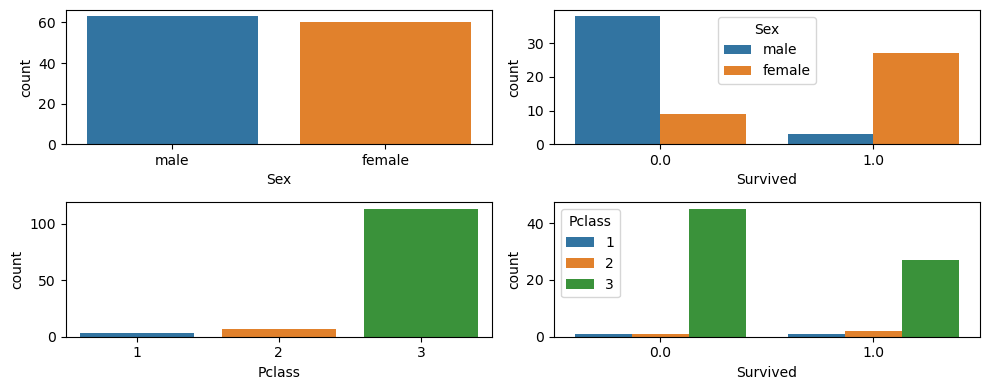

In [32]:
embarked_Q = titanic_data[titanic_data['Embarked'] == 'Q']

fig, axes = plt.subplots(2, 2, figsize=(10, 4))

sns.countplot(x=embarked_Q['Sex'], ax=axes[0][0])
sns.countplot(x=embarked_Q['Survived'], hue='Sex', data=embarked_Q, ax=axes[0][1])

sns.countplot(x=embarked_Q['Pclass'], ax=axes[1][0])
sns.countplot(x=embarked_Q['Survived'], hue='Pclass', data=embarked_Q, ax=axes[1][1])

plt.tight_layout()
plt.show()

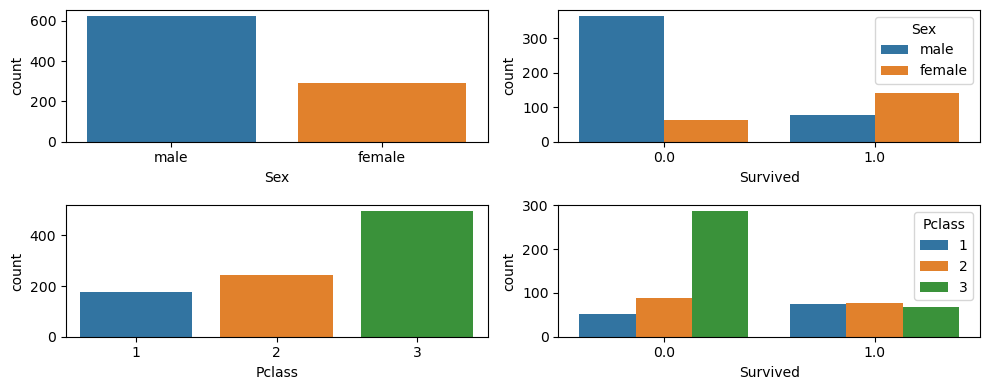

In [33]:
embarked_S = titanic_data[titanic_data['Embarked'] == 'S']

fig, axes = plt.subplots(2, 2, figsize=(10, 4))

sns.countplot(x=embarked_S['Sex'], ax=axes[0][0])
sns.countplot(x=embarked_S['Survived'], hue='Sex', data=embarked_S, ax=axes[0][1])

sns.countplot(x=embarked_S['Pclass'], ax=axes[1][0])
sns.countplot(x=embarked_S['Survived'], hue='Pclass', data=embarked_S, ax=axes[1][1])

plt.tight_layout()
plt.show()

#### <b> 2.9 Ticket </b>

In [34]:
print(f"Unique Tickets: {len(train_data['Ticket'].unique())}")

Unique Tickets: 681


This feature might not prodive vaulable information since it is categorical but having too many unique values.

<br>
<h3><b> 3. Data Preprocessing </b></h3>

#### <b> 3.1 Data Imputation </b>

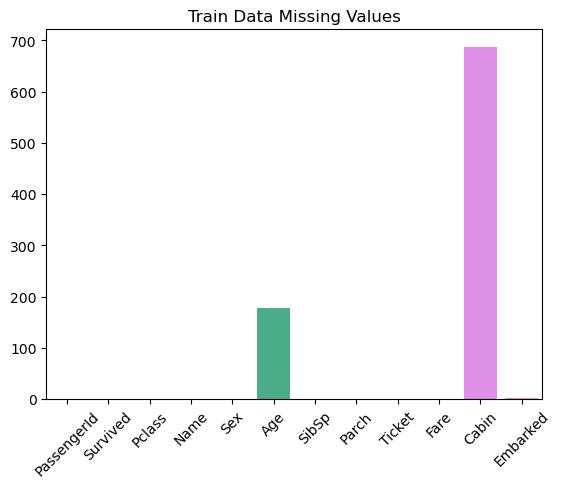

In [35]:
# check null
sns.barplot(x=train_data.columns, y=train_data.isnull().sum().values)
plt.xticks(rotation=45)
plt.title('Train Data Missing Values')
plt.show()

There are 3 features having missing values: Cabin, Age, and Embarked

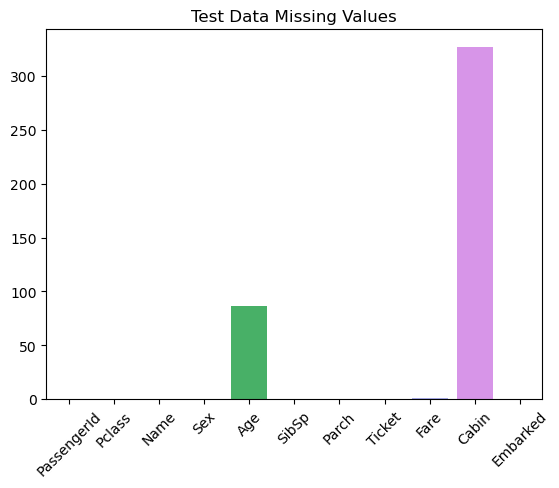

In [36]:
# check null
sns.barplot(x=test_data.columns, y=test_data.isnull().sum().values)
plt.xticks(rotation=45)
plt.title('Test Data Missing Values')
plt.show()

There are 3 features having missing values: Cabin, Age, and Fare

- <b>3.1.1 Age Data Imputation</b>

In [37]:
median_age = titanic_data.groupby(['Pclass','Sex'])['Age'].median()
median_age

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64

In [38]:
train_data['Age'] = train_data.apply(lambda x: median_age.loc[x['Pclass'], x['Sex']] if np.isnan(x['Age']) else x['Age'], axis = 1)

In [39]:
test_data['Age'] = test_data.apply(lambda x: median_age.loc[x['Pclass'], x['Sex']] if np.isnan(x['Age']) else x['Age'], axis = 1)

- <b>3.1.2 Fare Data Imputation</b>

In [40]:
test_data[test_data['Fare'].isnull()]


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [41]:
mean_fare = test_data['Fare'].mean()
test_data['Fare'] = test_data['Fare'].fillna(mean_fare)

- <b>3.1.3 Cabin Data Imputation</b>

In [42]:
# replace misisng value with letter X
train_data['Cabin'].fillna('Unknown', inplace=True)
test_data['Cabin'].fillna('Unknown', inplace=True)

In [43]:
train_data['Cabin'].str[0].value_counts()

Cabin
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

- <b>3.1.3 Embarked Data Imputation</b>

In [44]:
train_data[train_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [45]:
train_data['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [46]:
print(f'Most frequent value: {train_data["Embarked"].value_counts().idxmax()}')

Most frequent value: S


In [47]:
# fill null value with most frequent value
train_data['Embarked'].fillna(train_data["Embarked"].value_counts().idxmax(), inplace=True)

- <b>Check if all null values have been placed</b>

In [48]:
print('TRAIN_DATA')
train_data.info()
print('\n\n')
print('TEST_DATA')
test_data.info()

TRAIN_DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB



TEST_DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null 

<b>All missing values have been replaced</b>

#### <b> 3.2 Data Normalization </b>

In [49]:
scaler = RobustScaler()

train_data['Fare'] = scaler.fit_transform(train_data[['Fare']])

<br>
<h3><b> 4. Feature Selection/Engineering </b></h3>

#### <b> 4.1 Feature Creation </b>

- <b> 4.1.1 Fam_Size - combine SibSp and Parch</b>

In [50]:
train_data['Fam_Size'] = train_data['SibSp'] + train_data['Parch']
test_data['Fam_Size'] = test_data['SibSp'] + test_data['Parch']

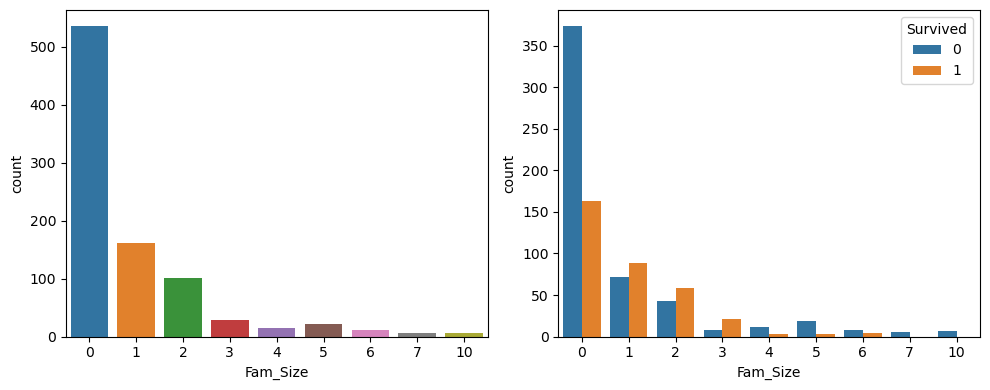

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=train_data['Fam_Size'], ax=axes[0])
sns.countplot(x=train_data['Fam_Size'], hue='Survived', data=train_data, ax=axes[1])

plt.tight_layout()
plt.show() 

Family size of 1, 2, and 3 are more likely to survive than other groups. Passgengers with family of more than 7 are less likely to surve.

- <b> 4.1.2 Deck - Group passengers by their (Cabin) Deck (the first letter of their Cabin's name)</b>

In [52]:
train_data['Deck'] = train_data['Cabin'].str[0]
test_data['Deck'] = test_data['Cabin'].str[0]

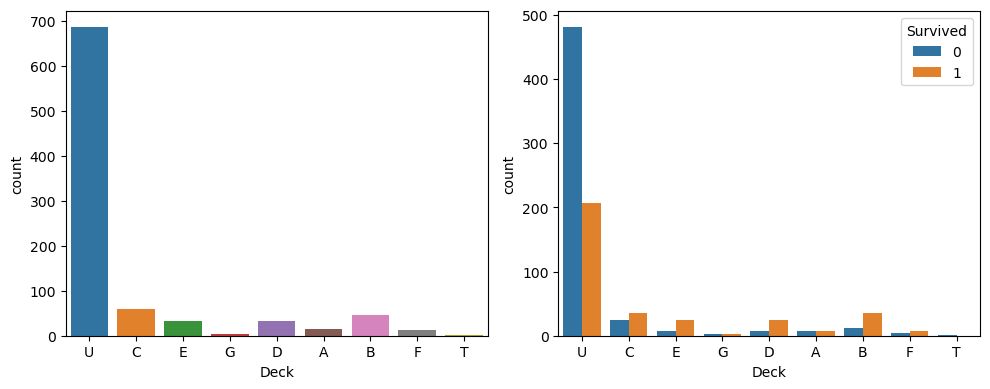

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=train_data['Deck'], ax=axes[0])
sns.countplot(x=train_data['Deck'], hue='Survived', data=train_data, ax=axes[1])

plt.tight_layout()
plt.show() 

Passengers with missing cabin value (unknown) are likely to die than passengers from other decks. 

- <b> 4.1.2 Age_Group - Group passengers by their Age with intervals of 5 or 10</b>

In [54]:
# define age bins
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]

# age labels
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']

train_data['Age_Group'] = pd.cut(train_data['Age'], bins=age_bins, labels=age_labels, right=False)
test_data['Age_Group'] = pd.cut(test_data['Age'], bins=age_bins, labels=age_labels, right=False)

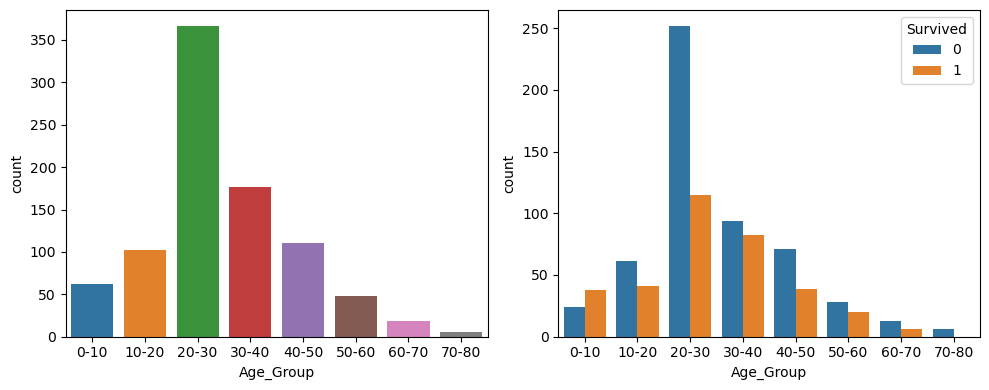

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=train_data['Age_Group'], ax=axes[0])
sns.countplot(x=train_data['Age_Group'], hue='Survived', data=train_data, ax=axes[1])

plt.tight_layout()
plt.show()

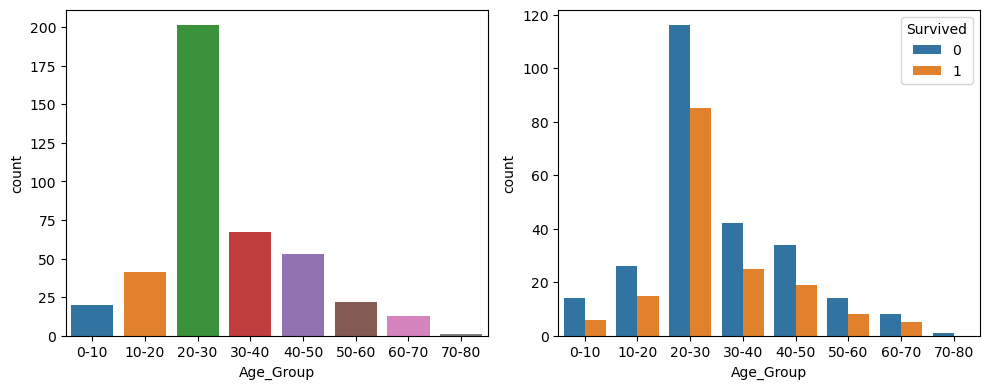

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=test_data['Age_Group'], ax=axes[0])
sns.countplot(x=test_data['Age_Group'], hue='Survived', data=train_data, ax=axes[1])

plt.tight_layout()
plt.show()

#### <b> 4.2 One-Hot-Encoding </b>

In [57]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Fam_Size', 'Deck',
       'Age_Group'],
      dtype='object')

In [58]:
train_data = pd.get_dummies(data=train_data, columns=['Sex'], drop_first=True)
test_data = pd.get_dummies(data=test_data, columns=['Sex'], drop_first=True)

In [59]:
categorical_features = ['Pclass', 'Age_Group', 'Fam_Size', 'Deck', 'Embarked']

train_data = pd.get_dummies(data=train_data, columns=categorical_features, prefix=categorical_features)
test_data = pd.get_dummies(data=test_data, columns=categorical_features, prefix=categorical_features)

In [60]:
train_data.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Age_Group_0-10', 'Age_Group_10-20', 'Age_Group_20-30',
       'Age_Group_30-40', 'Age_Group_40-50', 'Age_Group_50-60',
       'Age_Group_60-70', 'Age_Group_70-80', 'Fam_Size_0', 'Fam_Size_1',
       'Fam_Size_2', 'Fam_Size_3', 'Fam_Size_4', 'Fam_Size_5', 'Fam_Size_6',
       'Fam_Size_7', 'Fam_Size_10', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [61]:
train_data.shape[1]

42

In [62]:
test_data.columns

Index(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Age_Group_0-10', 'Age_Group_10-20', 'Age_Group_20-30',
       'Age_Group_30-40', 'Age_Group_40-50', 'Age_Group_50-60',
       'Age_Group_60-70', 'Age_Group_70-80', 'Fam_Size_0', 'Fam_Size_1',
       'Fam_Size_2', 'Fam_Size_3', 'Fam_Size_4', 'Fam_Size_5', 'Fam_Size_6',
       'Fam_Size_7', 'Fam_Size_10', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [63]:
test_data.shape[1]

40

In [64]:
train_data, test_data = train_data.align(test_data, axis=1, fill_value=0)


In [65]:
test_data.columns

Index(['Age', 'Age_Group_0-10', 'Age_Group_10-20', 'Age_Group_20-30',
       'Age_Group_30-40', 'Age_Group_40-50', 'Age_Group_50-60',
       'Age_Group_60-70', 'Age_Group_70-80', 'Cabin', 'Deck_A', 'Deck_B',
       'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fam_Size_0', 'Fam_Size_1',
       'Fam_Size_10', 'Fam_Size_2', 'Fam_Size_3', 'Fam_Size_4', 'Fam_Size_5',
       'Fam_Size_6', 'Fam_Size_7', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_male', 'SibSp', 'Survived',
       'Ticket'],
      dtype='object')

In [66]:
test_data.shape[1]

42

<br>
<h3><b> 5. Train Test Split </b></h3>

In [67]:
features = ['Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Age_Group_0-10', 'Age_Group_10-20', 'Age_Group_20-30',
       'Age_Group_30-40', 'Age_Group_40-50', 'Age_Group_50-60',
       'Age_Group_60-70', 'Age_Group_70-80', 'Fam_Size_0', 'Fam_Size_1',
       'Fam_Size_2', 'Fam_Size_3', 'Fam_Size_4', 'Fam_Size_5', 'Fam_Size_6',
       'Fam_Size_7', 'Fam_Size_10', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U', 'Embarked_C', 'Embarked_Q',
       'Embarked_S']

X = train_data[features]
y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)


<br>
<h3><b> 6. Model Selection </b></h3>

In [73]:
#from sklearn.neighbors import KNeighborsClassifier

#logmodel = LogisticRegression(max_iter=1000)
#sgdmodel = SGDClassifier()
xgbmodel = xgb.XGBClassifier(random_state = 42, objective='binary:logistic')
#RFmodel = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
#knn = KNeighborsClassifier()




<br>
<h3><b> 7. Model Training and Evaluation </b></h3>

In [74]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1, 3, 5, 7],
    'n_estimators': [50, 100, 150, 200 ],
    'colsample_bytree': [ 0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'min_child_weight': [1, 3, 5, 7 ],
}

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=xgbmodel, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
# Fit the model with GridSearchCV
with tf.device("/GPU:0"):

    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
#xgbmodel.fit(X_train, y_train)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
Accuracy: 0.8134328358208955


In [75]:
best_params

{'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100,
 'reg_alpha': 0.1}


# <b> Submission </b>

In [72]:
predictions = best_model.predict(test_data[features])

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
